In [1]:
import numpy as np
import os
import copy
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import open3d
import tqdm

import utils.registration as registration
import utils.pointcloud as pointcloud
import utils.fread as fread
import utils.functions as functions
from utils.config import Config

In [15]:
def get_subject_depth_std(sequence_dir):
    sequence_ts = fread.get_timstamps_from_images(sequence_dir, ".depth.png")
    depth_stds = []

    for t in tqdm.trange(len(sequence_ts)):
        std = registration.calc_std(os.path.join(sequence_dir, f"frame-{sequence_ts[t]}.depth.png"), 4000)
        depth_stds.append(std)
        
    return sequence_ts, depth_stds

In [88]:
trial = "trial_1"
sequence = "04"

subject_1 = f"data/raw_data/exp_1/{trial}/secondary/subject-1/{sequence}/frames"
subject_2 = f"data/raw_data/exp_1/{trial}/secondary/subject-2/{sequence}/frames"

sequence_ts_s1, depth_stds_s1 = get_subject_depth_std(subject_1)
sequence_ts_s2, depth_stds_s2 = get_subject_depth_std(subject_2)

100%|██████████| 455/455 [00:03<00:00, 132.89it/s]


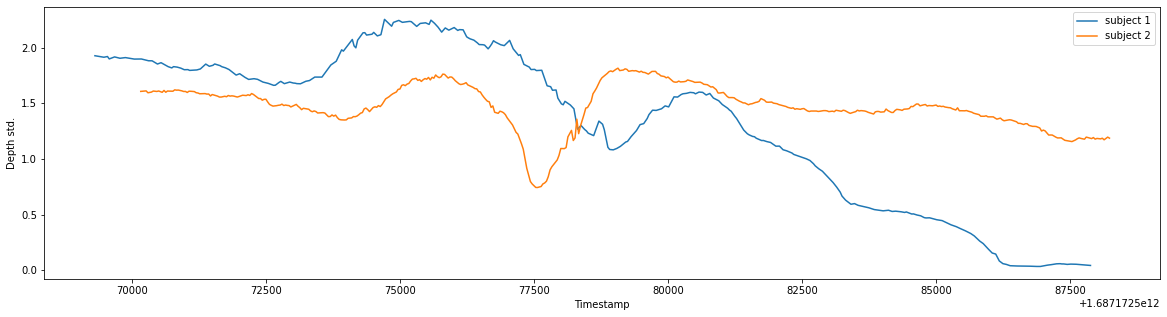

In [89]:
plt.figure(figsize=(20, 5))
plt.plot(sequence_ts_s1, depth_stds_s1, label="subject 1")
plt.plot(sequence_ts_s2, depth_stds_s2, label="subject 2")
plt.legend()
plt.xlabel("Timestamp")
plt.ylabel("Depth std.")
plt.savefig(f"data/videos/combined_exp_1/{trial}__{sequence}.png")

In [28]:
def get_frame_sequence(sequence_dir):
    sequence_ts = os.listdir(sequence_dir)
    sequence_ts = [int(sequence_ts[i].split(".")[0].split("-")[1]) for i in range(len(sequence_ts)) if sequence_ts[i].endswith(".depth.png")]
    sequence_ts = sorted(sequence_ts)
    images = []
 
    for t in sequence_ts:
        img = cv2.imread(os.path.join(sequence_dir, f"frame-{t}.depth.png"), cv2.IMREAD_ANYDEPTH)
        img = img / (9 * 4000)
        img = img * 255
        img = np.where(img > 255, 255, img)
        img = np.array(img, dtype=np.uint8)
        img = cv2.applyColorMap(img, cv2.COLORMAP_JET)
        images.append(img)
 
    return sequence_ts, images

In [67]:
trial = "trial_1"
sequence = "04"

subject_1 = f"data/raw_data/exp_1/{trial}/secondary/subject-1/{sequence}/frames"
subject_2 = f"data/raw_data/exp_1/{trial}/secondary/subject-2/{sequence}/frames"

In [68]:
sequence_ts_s1, images_s1 = get_frame_sequence(subject_1)
sequence_ts_s2, images_s2 = get_frame_sequence(subject_2)

In [69]:
indices = []

for i in range(len(sequence_ts_s1)):
    nearest_t = functions.nearest(sequence_ts_s2, sequence_ts_s1[i])
    if abs(sequence_ts_s1[i] - nearest_t) < 100:
        j = sequence_ts_s2.index(nearest_t)
        indices.append([i, j])

In [70]:
video = cv2.VideoWriter(f"data/videos/combined_exp_1/{trial}__{sequence}.avi", cv2.VideoWriter_fourcc(*'XVID'), 30, (640 * 2, 480))

for i, j in indices:
    video.write(np.hstack((images_s1[i], images_s2[j])))
    
video.release()

In [109]:
def local_trajectory(config: Config):
    output_file = config.get_output_file(f"{config.get_file_name()}.npz")
    
    if not os.path.exists(output_file):
        print("No local trajectory found for this sequence.")
        return
        
    data = np.load(output_file)
    
    sequence_ts = data["sequence_ts"]
    trajectory_t = data["trajectory_t"]
    local_t = data["local_t"]
    
    pcd_dir = f"data/point_clouds/{config.experiment}/{config.trial}/{config.subject}/{config.sequence}"
    
    num_frames = len(sequence_ts)
    
    local_pcds = []
    
    for t in tqdm.trange(num_frames):
        if np.sum(local_t[t]) == 4:
            continue
        
        pcd_file = os.path.join(pcd_dir, f"{sequence_ts[t]}.secondary.pcd")
        pcd = open3d.io.read_point_cloud(pcd_file)
        pcd.paint_uniform_color(pointcloud.random_color())
        pcd.transform(trajectory_t[t])
        local_pcds.append(pcd)
        
    trajectory_pcd = pointcloud.merge_pcds(local_pcds, config.voxel_size)
    # pointcloud.view(trajectory_pcd)
    return trajectory_pcd

In [108]:
config = Config(
    sequence_dir="data/raw_data",
    feature_dir="data/features",
    output_dir="data/trajectories/local/FPFH_0.03",
    experiment="exp_1",
    trial="trial_2",
    subject="subject-1",
    sequence="02",
    groundtruth_dir="data/trajectories/groundtruth",
)

config.voxel_size=0.03
config.target_fps=20
config.min_std=0.5

In [113]:
for trial in os.listdir(os.path.join(config.sequence_dir, config.experiment)):
    if not trial.startswith("trial"):
        continue
    config.trial = trial
    for subject in os.listdir(os.path.join(config.sequence_dir, config.experiment, config.trial, "secondary")):
        config.subject = subject    
        for sequence in os.listdir(os.path.join(config.sequence_dir, config.experiment, config.trial, "secondary", config.subject)):
            config.sequence = sequence
            print(f"Processing: {config.experiment} >> {config.trial} >> {config.subject} >> {config.sequence}")
            
            pcd = local_trajectory(config)
            open3d.io.write_point_cloud(f"data/videos/combined_exp_1/{trial}__{sequence}.pcd", pcd)

Processing: exp_1 >> trial_1 >> subject-1 >> 01


100%|██████████| 270/270 [00:00<00:00, 1273.86it/s]


Processing: exp_1 >> trial_1 >> subject-1 >> 02


100%|██████████| 238/238 [00:00<00:00, 1228.95it/s]


Processing: exp_1 >> trial_1 >> subject-1 >> 03


100%|██████████| 258/258 [00:00<00:00, 1141.55it/s]


Processing: exp_1 >> trial_1 >> subject-1 >> 04


100%|██████████| 249/249 [00:01<00:00, 159.61it/s]


Processing: exp_1 >> trial_1 >> subject-2 >> 01


100%|██████████| 357/357 [00:02<00:00, 154.42it/s]


Processing: exp_1 >> trial_1 >> subject-2 >> 02


100%|██████████| 359/359 [00:02<00:00, 161.85it/s]


Processing: exp_1 >> trial_1 >> subject-2 >> 03


100%|██████████| 360/360 [00:02<00:00, 151.54it/s]


Processing: exp_1 >> trial_1 >> subject-2 >> 04


100%|██████████| 329/329 [00:01<00:00, 169.25it/s]


Processing: exp_1 >> trial_2 >> subject-1 >> 01


100%|██████████| 266/266 [00:01<00:00, 158.80it/s]


Processing: exp_1 >> trial_2 >> subject-1 >> 02


100%|██████████| 246/246 [00:00<00:00, 1216.04it/s]


Processing: exp_1 >> trial_2 >> subject-1 >> 03


100%|██████████| 246/246 [00:01<00:00, 159.04it/s]


Processing: exp_1 >> trial_2 >> subject-2 >> 01


100%|██████████| 351/351 [00:00<00:00, 1089.07it/s]


Processing: exp_1 >> trial_2 >> subject-2 >> 02


100%|██████████| 346/346 [00:00<00:00, 1237.44it/s]


Processing: exp_1 >> trial_2 >> subject-2 >> 03


100%|██████████| 344/344 [00:02<00:00, 147.41it/s]


In [112]:
open3d.io.write_point_cloud("sample.pcd", pcd)

True

In [24]:
experiment_dir = "data/raw_data/exp_2/arducam_tof/"

for trial in os.listdir(experiment_dir):
    for camera in os.listdir(os.path.join(experiment_dir, trial)):
        camera_dir = os.path.join(experiment_dir, trial, camera)
        print(f"Processing: {camera_dir}")
        sequence_ts = fread.get_timstamps_from_images(camera_dir, ".png")
        
        images = []

        for t in sequence_ts:
            img = cv2.imread(os.path.join(camera_dir, f"frame-{t}.png"), cv2.IMREAD_ANYDEPTH)
            img = np.array(img, dtype=np.uint8)
            img = cv2.applyColorMap(img, cv2.COLORMAP_JET)
            images.append(img)
        
        video = cv2.VideoWriter(f"data/videos/arducam_tof/{trial}_{camera}.avi", cv2.VideoWriter_fourcc(*'XVID'), 30, (240, 180))

        for i in range(len(images)):
            video.write(images[i])
            
        video.release()

Processing: data/raw_data/exp_2/arducam_tof/trial_1\camera_1
Processing: data/raw_data/exp_2/arducam_tof/trial_1\camera_2
Processing: data/raw_data/exp_2/arducam_tof/trial_1\camera_3
Processing: data/raw_data/exp_2/arducam_tof/trial_1\camera_4
Processing: data/raw_data/exp_2/arducam_tof/trial_1\camera_5
Processing: data/raw_data/exp_2/arducam_tof/trial_2\camera_1
Processing: data/raw_data/exp_2/arducam_tof/trial_2\camera_2
Processing: data/raw_data/exp_2/arducam_tof/trial_2\camera_3
Processing: data/raw_data/exp_2/arducam_tof/trial_2\camera_4
Processing: data/raw_data/exp_2/arducam_tof/trial_3\camera_1
Processing: data/raw_data/exp_2/arducam_tof/trial_3\camera_2
Processing: data/raw_data/exp_2/arducam_tof/trial_3\camera_3
Processing: data/raw_data/exp_2/arducam_tof/trial_4\camera_1
Processing: data/raw_data/exp_2/arducam_tof/trial_4\camera_2
Processing: data/raw_data/exp_2/arducam_tof/trial_4\camera_3
Processing: data/raw_data/exp_2/arducam_tof/trial_4\camera_4
Processing: data/raw_dat

In [35]:
camera_dir = "data/raw_data/exp_2/hololens/trial_1"
sequence_ts = fread.get_timstamps_from_images(camera_dir, ".png")

images = []

for t in sequence_ts:
    img = cv2.imread(os.path.join(camera_dir, f"frame-{t}.png"), cv2.IMREAD_ANYDEPTH)
    img = np.clip(img, 0, 7000) / 7000 * 255
    img = np.array(img, dtype=np.uint8)
    img = cv2.applyColorMap(img, cv2.COLORMAP_JET)
    images.append(img)
    
    
video = cv2.VideoWriter(f"data/videos/sample.avi", cv2.VideoWriter_fourcc(*'XVID'), 5, (320, 288))

for i in range(len(images)):
    video.write(images[i])
    
video.release()

In [32]:
img = cv2.imread(os.path.join(camera_dir, f"frame-{t}.png"), cv2.IMREAD_ANYDEPTH)

In [33]:
img.max()

6899